In [1]:
import numpy as np
import scipy

from scipy.interpolate import interp1d

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import lightning as L

# Load Dataset

In [2]:
import os
os.path.abspath('.')

'/home/reinhardt/ml-pws/notebooks'

In [3]:
data = scipy.io.loadmat('../data/barmovie0113extended.data', squeeze_me=True)
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'rep_begin_time', 'rep_end_time', 'PickedCells', 'SpikeTimes', 'peak_times', 'stim'])

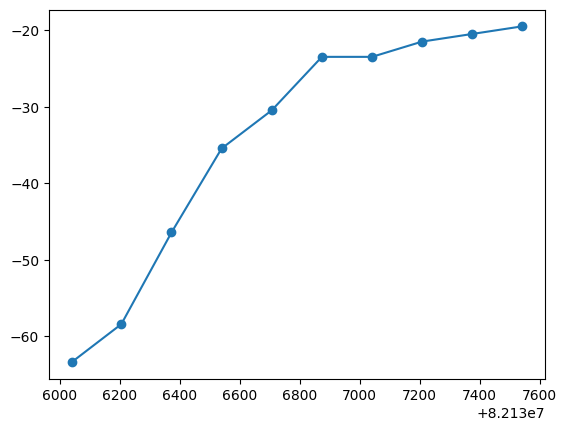

In [4]:
plt.plot(data['peak_times'][-10:], data['stim'][-10:], 'o-')

In [5]:
data['stim'].shape, data['peak_times'].shape

((487889,), (487891,))

In [6]:
dt = 1e-4

(66.0316, 71.0316)

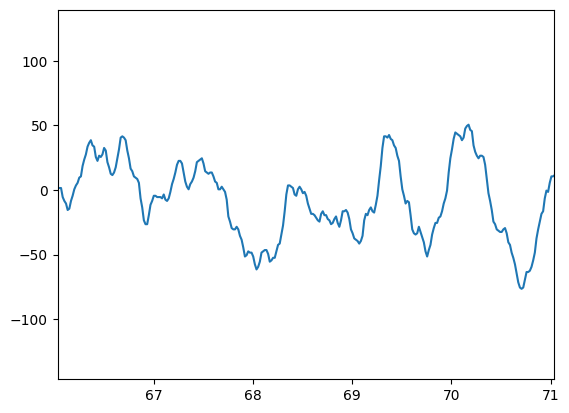

In [7]:
plt.plot(data['peak_times'][1:-1] * dt, data['stim'])
plt.xlim(data['peak_times'][0] * dt, data['peak_times'][0]*dt+5)

In [8]:
len(data['SpikeTimes'])

230

(180.0, 300.0)

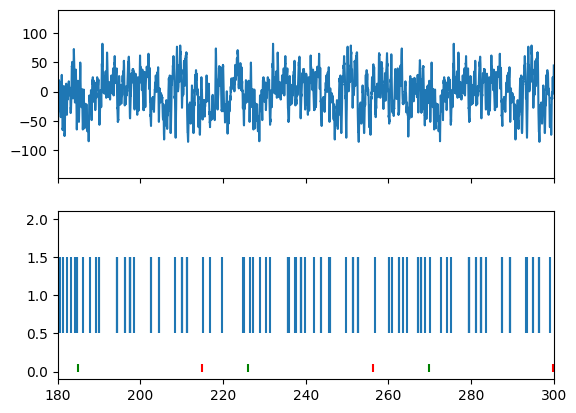

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(data['peak_times'][1:-1] * dt, data['stim'])
ax2.eventplot(data['SpikeTimes'][3] * dt)
ax2.vlines(data['rep_begin_time'] * dt, 0, 0.1, color='green')
ax2.vlines(data['rep_end_time'] * dt, 0, 0.1, color='red')
ax2.set_xlim(180, 300)

In [10]:
peak_times = data['peak_times'][:-2]
rep_mask = (peak_times[:, np.newaxis] >= data['rep_begin_time']) * (peak_times[:, np.newaxis] < data['rep_end_time'])
spike_times = data['SpikeTimes'][1]
spike_mask = (spike_times[:, np.newaxis] >= data['rep_begin_time']) * (spike_times[:, np.newaxis] < data['rep_end_time'])
rep_mask.shape, spike_mask.shape

((487889, 136), (4127, 136))

In [11]:
spike_times[spike_mask[:, 0]] * dt

array([188.4099, 188.4688, 188.4906, 191.0803, 194.2761, 194.2815,
       198.2389, 200.4405, 203.1024, 203.5345, 203.6239, 203.777 ,
       206.957 , 206.9615, 207.017 , 209.3561, 213.7506])

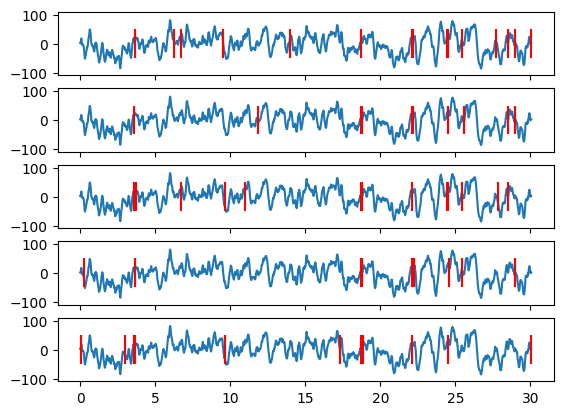

In [12]:
fig, axs = plt.subplots(5, sharex=True)

for i, ax in zip([10,20,30,45,120], axs):
    t0 = data['rep_begin_time'][i] * dt
    mask = rep_mask[:, i]
    t = peak_times[mask] * dt
    ax.plot(t - t0, data['stim'][mask])
    ax.eventplot(spike_times[spike_mask[:, i]] * dt - t0, linelengths=100.0, color='red')

In [13]:
t_start = data['rep_begin_time'][0]
t_end = data['rep_end_time'][10]
grid = np.arange(t_start, t_end, 50)
grid.shape

(100547,)

<StemContainer object of 3 artists>

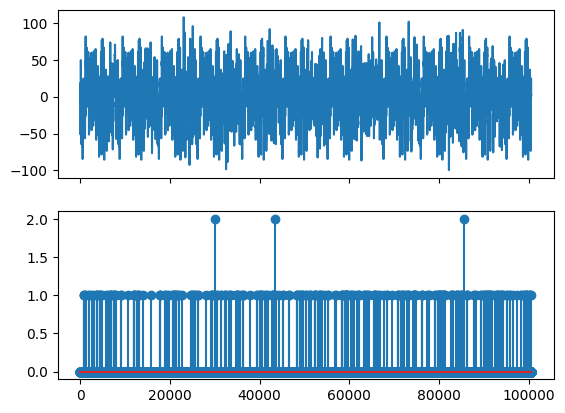

In [14]:
idx = np.searchsorted(peak_times, grid)
stimulus = data['stim'][idx]
hist, _ = np.histogram(spike_times, bins=np.concat([grid, [t_end]]))
f, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(stimulus)
ax2.stem(hist)

In [203]:
from torch.utils.data import Dataset

class NeuronDataSet(Dataset):
    def __init__(self, filename, neurons = [0], interval = [0.0, 1.0], delta_t = 50):
        super().__init__()
        self.data = scipy.io.loadmat(filename, squeeze_me=True)
        self.neurons = neurons
        self.interval = interval
        self.delta_t = delta_t
        self.stimulus_std = np.std(self.data['stim'])

    def __len__(self):
        return len(self.data['rep_begin_time'])
    
    def __getitem__(self, index):
        t1 = self.data['rep_begin_time'][index]
        t2 = self.data['rep_end_time'][index]
        return self.time_discretized_spikes(*np.interp(self.interval, [0.0, 1.0], [t1, t2]))

    def time_discretized_spikes(self, t_start, t_end):
        grid = torch.arange(t_start, t_end, self.delta_t, dtype=torch.float32)

        peak_times = torch.tensor(self.data['peak_times'][:-2])
        idx = torch.searchsorted(peak_times, grid)
        stimulus = torch.tensor(self.data['stim'][idx] / self.stimulus_std, dtype=torch.float32)

        spikes_binned = []
        for n in self.neurons:
            spike_times = torch.tensor(self.data['SpikeTimes'][n], dtype=torch.float32)
            hist, _ = torch.histogram(spike_times, bins=torch.concat([grid, torch.tensor([t_end], dtype=torch.float32)]))
            spikes_binned.append(torch.clamp(hist, 0, 1))

        return stimulus, torch.stack(spikes_binned, dim=-1)

def collate_time_series(batch):
    # first unzip the batch
    s_batch, x_batch = zip(*batch)

    s_padded = nn.utils.rnn.pad_sequence(s_batch, batch_first=False, padding_value=0.0)
    x_padded = nn.utils.rnn.pad_sequence(x_batch, batch_first=False, padding_value=0.0)

    return s_padded, x_padded

In [204]:
train_dataset = NeuronDataSet('../data/barmovie0113extended.data', [0], [0.0, 0.7])
validation_dataset = NeuronDataSet('../data/barmovie0113extended.data', [0], [0.7, 1.0])
# train_dataset, validation_dataset = torch.utils.data.random_split(dataset, [0.7, 0.3])
train_dataset[0][0].shape, validation_dataset[0][0].shape

(torch.Size([4211]), torch.Size([1805]))

In [210]:
class ConditionalSpikeModel(nn.Module):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1):
        super().__init__()
        self.hidden_dim = hidden_size
        self.num_layers = num_layers
        self.n_neurons = n_neurons

        # RNN layer (stimulus dimension is 1)
        self.rnn = nn.GRU(1 + n_neurons, hidden_size, num_layers, batch_first=False, dropout=0.3)
        self.h_0 = nn.Parameter(torch.randn(num_layers, 1, hidden_size))

        # Linear layer to output spike prob for each neuron
        self.output_layer = nn.Linear(hidden_size, n_neurons)

    def forward(self, s: torch.Tensor, x: torch.Tensor):
        seq_len, batch_size, n_neurons = x.size()

        if seq_len != s.size(0):
            raise ValueError(f"Sequence lengths do not match.")

        if n_neurons != self.n_neurons:
            raise ValueError(f"Wrong shape of x: {x.size()}. Expected last dimension {self.n_neurons}.")

        if s.ndim == 2:
            s = s.unsqueeze(-1)

        # shift right
        x = x.roll(1, 0)  # (seq_len, batch_size, n_neurons)
        x[0, :, :] = 0.0

        # Expand h_0 to match batch size
        h_0 = self.h_0.expand(-1, batch_size, -1).contiguous()

        # Forward through RNN
        rnn_out, _ = self.rnn(torch.cat([s, x], dim=2), h_0)

        output = self.output_layer(rnn_out)  # (seq_len, batch_size, n_neurons)

        # returns the logits
        return output

In [272]:
class SpikeRnn(L.LightningModule):
    def __init__(self, n_neurons: int, hidden_size: int, num_layers: int = 1):
        super().__init__()
        self.net = ConditionalSpikeModel(n_neurons, hidden_size, num_layers)
        self.loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(350.0))

    def training_step(self, batch, batch_idx):
        s, x = batch
        x = torch.clamp(x, 0, 1)
        logits = self.net(s, x)
        train_loss = self.loss_fn(logits, x)
        self.log("train_loss", train_loss, prog_bar=True, on_epoch=True)
        return train_loss
    
    def validation_step(self, batch, batch_idx):
        s, x = batch
        x = torch.clamp(x, 0, 1)
        logits = self.net(s, x)
        val_loss = self.loss_fn(logits, x)
        
        # Log validation loss
        self.log("val_loss", val_loss, prog_bar=True, on_epoch=True)
        return val_loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [273]:
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_time_series)
val_loader = DataLoader(validation_dataset, batch_size=126, collate_fn=collate_time_series)
spike_rnn = SpikeRnn(1, 64, 2)
trainer = L.Trainer(max_epochs=25)
trainer.fit(model=spike_rnn, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



  | Name    | Type                  | Params | Mode 
----------------------------------------------------------
0 | net     | ConditionalSpikeModel | 38.2 K | train
1 | loss_fn | BCEWithLogitsLoss     | 0      | train
----------------------------------------------------------
38.2 K    Trainable params
0         Non-trainable params
38.2 K    Total params
0.153     Total estimated model params size (MB)
4         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/reinhardt/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


/home/reinhardt/.local/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/reinhardt/.local/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 24: 100%|██████████| 3/3 [00:08<00:00,  0.34it/s, v_num=61, train_loss_step=0.238, val_loss=0.615, train_loss_epoch=0.239]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 3/3 [00:08<00:00,  0.34it/s, v_num=61, train_loss_step=0.238, val_loss=0.615, train_loss_epoch=0.239]


In [227]:

nn.BCEWithLogitsLoss(pos_weight=torch.tensor(100.0))(logits, x)

tensor(0.8402)

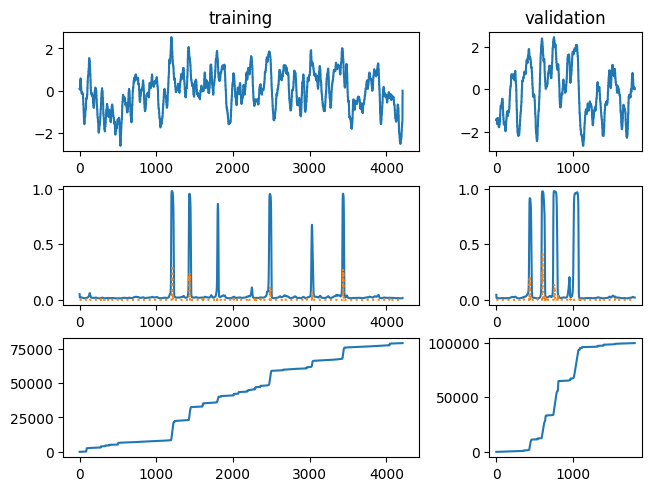

In [274]:
s_train, x_train = collate_time_series([v for v in train_dataset])
s_val, x_val = collate_time_series([v for v in validation_dataset])
spike_rnn.net.eval()

fig, axs = plt.subplots(3, 2, width_ratios=[0.7, 0.3], constrained_layout=True)

for ax, s, title in zip(axs[0, :], [s_train, s_val], ["training", "validation"]):
    ax.plot(s.mean(1))
    ax.set_title(title)

for ax, ax_loss, s, x in zip(axs[1, :], axs[2, :], [s_train, s_val], [x_train, x_val]):
    with torch.no_grad():
        logits = spike_rnn.net(s, x)
    ax.plot(nn.functional.sigmoid(logits).mean(1)[:, 0])
    ax.plot(x.mean(1)[:, 0], linestyle='dotted')
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(100.0), reduction='none')
    ax_loss.plot(loss_fn(logits, x).sum(1)[:, 0].cumsum(0))

# ax1.plot(s.mean(1))

#     ax2.plot(nn.functional.sigmoid(logits).mean(1)[:, 0])
# ax2.plot(x.mean(1)[:, 0], linestyle='dotted')

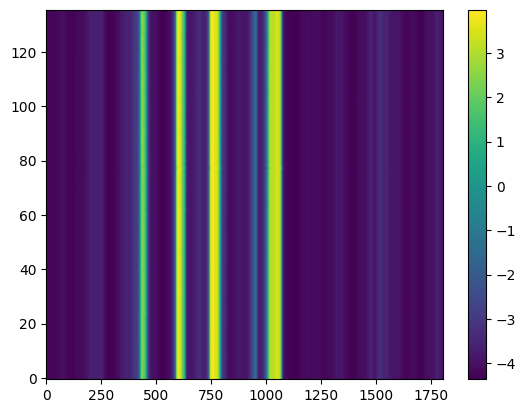

In [276]:
plt.imshow(logits[:, :, 0].T, aspect='auto', origin='lower')
plt.colorbar()

In [245]:
x.numel() / (x > 0.5).sum()

tensor(341.6078)

In [237]:
spike_rnn.loss_fn(logits, x), spike_rnn.loss_fn(-7 * torch.ones_like(logits), x)

(tensor(0.1212), tensor(1.0884))

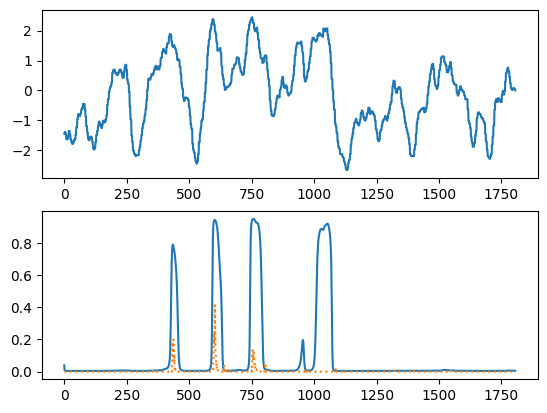

In [239]:
s, x = collate_time_series([v for v in validation_dataset])
spike_rnn.net.eval()

fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(s.mean(1))
with torch.no_grad():
    logits = spike_rnn.net(s, x)
    ax2.plot(nn.functional.sigmoid(logits).mean(1)[:, 0])
ax2.plot(x.mean(1)[:, 0], linestyle='dotted')

In [233]:
nn.functional.sigmoid(spike_rnn.net(s, x)).shape

torch.Size([1806, 136, 1])